In [382]:
import sys
sys.path.insert(0, '..')

In [383]:
# Basic imports
import jax.numpy as np
import jax.random as jr
import jax.scipy as jsp
import jax
import numpy

#jax.config.update("jax_enable_x64", True)

# Optimisation imports
import zodiax as zdx
import optax

# dLux imports
import dLux as dl
import dLux.utils as dlu

# Visualisation imports
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72

from detectors import *
from apertures import *
from models import *
from fisher import *
from stats import posterior

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams["font.size"] = 24

def set_array(pytree):
    dtype = np.float64 if jax.config.x64_enabled else np.float32
    floats, other = eqx.partition(pytree, eqx.is_inexact_array_like)
    floats = jtu.tree_map(lambda x: np.array(x, dtype=dtype), floats)
    return eqx.combine(floats, other)

In [384]:
wid = 80
oversample = 4

optics = NICMOSOptics(512, wid, oversample)

detector = NICMOSDetector(oversample, wid)

# n458
data = '../data/MAST_2024-09-19T06_48_02.332Z/HST/'

# n581
data = '../data/MAST_2024-09-23T06_53_22.463Z/HST/'

#hyades
data = '../data/MAST_2024-09-26T22_53_13.719Z/HST/'

data = '../data/MAST_2024-09-27T00_15_31.056Z/HST/'

files = """
na2a12jmq_cal.fits
na2a12jnq_cal.fits
na2a12joq_cal.fits
na2a12jpq_cal.fits
na2a12jqq_cal.fits
na2a12jxq_cal.fits
na2a12jzq_cal.fits
na2a12k0q_cal.fits
na2a12k1q_cal.fits
na2a12k2q_cal.fits
na2a12k9q_cal.fits
na2a12kbq_cal.fits
na2a12kcq_cal.fits
na2a12kdq_cal.fits
na2a12keq_cal.fits
na2a12klq_cal.fits
na2a12knq_cal.fits
na2a12koq_cal.fits
na2a12kpq_cal.fits
na2a12kqq_cal.fits
na2a12kxq_cal.fits
na2a12kzq_cal.fits
na2a12l0q_cal.fits
na2a12l1q_cal.fits
na2a12l2q_cal.fits
na2a12lgq_cal.fits
na2a12liq_cal.fits
na2a12ljq_cal.fits
na2a12lkq_cal.fits
na2a12llq_cal.fits
na2a12lsq_cal.fits
na2a12luq_cal.fits
na2a12lvq_cal.fits
na2a12lwq_cal.fits
na2a12lxq_cal.fits
na2a12m4q_cal.fits
na2a12m6q_cal.fits
na2a12m7q_cal.fits
na2a12m8q_cal.fits
na2a12m9q_cal.fits
na2a12mgq_cal.fits
na2a12miq_cal.fits
na2a12mjq_cal.fits
na2a12mkq_cal.fits
na2a12mlq_cal.fits
na2a12msq_cal.fits
na2a12muq_cal.fits
na2a12mvq_cal.fits
na2a12mwq_cal.fits
na2a12mxq_cal.fits
na2a12n4q_cal.fits
na2a12n6q_cal.fits
na2a12n7q_cal.fits
na2a12n8q_cal.fits
na2a12n9q_cal.fits
""".split()

print(files)


exposures = [exposure_from_file(data+f, SinglePointFit(), crop=wid) for f in files][:10]

['na2a12jmq_cal.fits', 'na2a12jnq_cal.fits', 'na2a12joq_cal.fits', 'na2a12jpq_cal.fits', 'na2a12jqq_cal.fits', 'na2a12jxq_cal.fits', 'na2a12jzq_cal.fits', 'na2a12k0q_cal.fits', 'na2a12k1q_cal.fits', 'na2a12k2q_cal.fits', 'na2a12k9q_cal.fits', 'na2a12kbq_cal.fits', 'na2a12kcq_cal.fits', 'na2a12kdq_cal.fits', 'na2a12keq_cal.fits', 'na2a12klq_cal.fits', 'na2a12knq_cal.fits', 'na2a12koq_cal.fits', 'na2a12kpq_cal.fits', 'na2a12kqq_cal.fits', 'na2a12kxq_cal.fits', 'na2a12kzq_cal.fits', 'na2a12l0q_cal.fits', 'na2a12l1q_cal.fits', 'na2a12l2q_cal.fits', 'na2a12lgq_cal.fits', 'na2a12liq_cal.fits', 'na2a12ljq_cal.fits', 'na2a12lkq_cal.fits', 'na2a12llq_cal.fits', 'na2a12lsq_cal.fits', 'na2a12luq_cal.fits', 'na2a12lvq_cal.fits', 'na2a12lwq_cal.fits', 'na2a12lxq_cal.fits', 'na2a12m4q_cal.fits', 'na2a12m6q_cal.fits', 'na2a12m7q_cal.fits', 'na2a12m8q_cal.fits', 'na2a12m9q_cal.fits', 'na2a12mgq_cal.fits', 'na2a12miq_cal.fits', 'na2a12mjq_cal.fits', 'na2a12mkq_cal.fits', 'na2a12mlq_cal.fits', 'na2a12ms

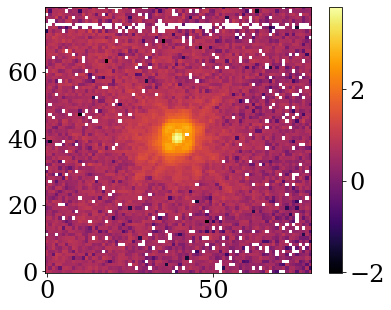

In [385]:
n = 0
plt.imshow(np.log10(exposures[n].data/exposures[n].err))
plt.colorbar()

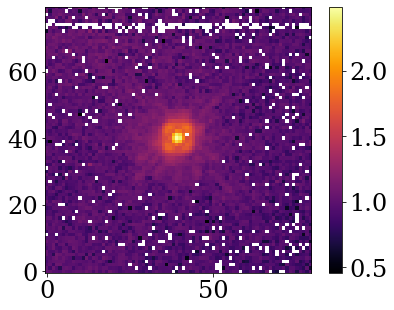

In [386]:
plt.imshow(exposures[0].data**0.125)
plt.colorbar()

In [387]:
params = {
    "fluxes": {},
    "positions": {},
    "slope": {},
    "contrast": {},
    #"separation": 6.,#18.,
    #"position_angle": 45.,#30.,#80.,#40.,
    "aberrations": {},
    "cold_mask_shift": {},
    "cold_mask_rot": {},
    "cold_mask_scale": {},
    "cold_mask_shear": {},
    "primary_scale": {},
    "primary_rot": {},
    "primary_shear": {},
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,
    #"scale": 0.0434735,
    #"rot": 0.0
}

for exp in exposures:
    params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([0.,0.])#np.asarray([-6.,-7.])#np.asarray([-8.,-2.])#np.asarray([-6.,-7.])
    params["fluxes"][exp.fit.get_key(exp, "fluxes")] = np.log10(np.nansum(exp.data))
    params["slope"][exp.fit.get_key(exp, "slope")] = np.zeros(5)#.at[0].set(1)
    #params["aberrations"] = injected_params["aberrations"]
    params["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.zeros(26)#jr.uniform(jr.key(0), (8,),minval=-4e-8, maxval=4e-8) #np.asarray([-8.59023084e-10,  1.77049982e-09, -4.45293089e-09, -3.70890613e-08,2.03658617e-08,  1.08092528e-08, -2.77077727e-09,  1.86458672e-09])*0.9#jr.uniform(jr.key(0), (8,),minval=-2e-8, maxval=2e-8)#np.zeros(8)#np.ones(8)*1e-8
    params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = np.asarray([0.06, 0.06])*1e2
    params["cold_mask_rot"][exp.fit.get_key(exp, "cold_mask_rot")] = 45.
    params["cold_mask_scale"][exp.fit.get_key(exp, "cold_mask_scale")] = np.asarray([1.,1.])
    params["cold_mask_shear"][exp.fit.get_key(exp, "cold_mask_shear")] = np.asarray([0.,0.])
    params["primary_rot"][exp.fit.get_key(exp, "primary_rot")] = 45.
    params["primary_scale"][exp.fit.get_key(exp, "primary_scale")] = np.asarray([1.,1.])
    params["primary_shear"][exp.fit.get_key(exp, "primary_shear")] = np.asarray([0.,0.])
    #params["contrast"][exp.fit.get_key(exp, "contrast")] = 1.


model = set_array(NICMOSModel(exposures, params, optics, detector))

params = ModelParams(params)

In [388]:
params

ModelParams(
  params={
    'fluxes':
    {'F110W': f32[]},
    'positions':
    {
      'na2a12jmq':
      f32[2],
      'na2a12jnq':
      f32[2],
      'na2a12joq':
      f32[2],
      'na2a12jpq':
      f32[2],
      'na2a12jqq':
      f32[2],
      'na2a12jxq':
      f32[2],
      'na2a12jzq':
      f32[2],
      'na2a12k0q':
      f32[2],
      'na2a12k1q':
      f32[2],
      'na2a12k2q':
      f32[2]
    },
    'slope':
    {'F110W': f32[5]},
    'contrast':
    {},
    'aberrations':
    {
      'na2a12jmq':
      f32[26],
      'na2a12jnq':
      f32[26],
      'na2a12joq':
      f32[26],
      'na2a12jpq':
      f32[26],
      'na2a12jqq':
      f32[26],
      'na2a12jxq':
      f32[26],
      'na2a12jzq':
      f32[26],
      'na2a12k0q':
      f32[26],
      'na2a12k1q':
      f32[26],
      'na2a12k2q':
      f32[26]
    },
    'cold_mask_shift':
    {'F110W': f32[2]},
    'cold_mask_rot':
    {'F110W': 45.0},
    'cold_mask_scale':
    {'F110W': f32[2]},
    'cold_mask_s

In [389]:
print(params.params)

{'fluxes': {'F110W': Array(4.279797, dtype=float32)}, 'positions': {'na2a12jmq': Array([0., 0.], dtype=float32), 'na2a12jnq': Array([0., 0.], dtype=float32), 'na2a12joq': Array([0., 0.], dtype=float32), 'na2a12jpq': Array([0., 0.], dtype=float32), 'na2a12jqq': Array([0., 0.], dtype=float32), 'na2a12jxq': Array([0., 0.], dtype=float32), 'na2a12jzq': Array([0., 0.], dtype=float32), 'na2a12k0q': Array([0., 0.], dtype=float32), 'na2a12k1q': Array([0., 0.], dtype=float32), 'na2a12k2q': Array([0., 0.], dtype=float32)}, 'slope': {'F110W': Array([0., 0., 0., 0., 0.], dtype=float32)}, 'contrast': {}, 'aberrations': {'na2a12jmq': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 'na2a12jnq': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 'na2a12joq': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
 

In [390]:
def scheduler(lr, start, *args):
    shed_dict = {start: 1e10}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e10, shed_dict)

base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)

opt = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))

base_adam = lambda vals: optax.adam(vals)
opta = lambda lr, start, *schedule: base_adam(scheduler(lr, start, *schedule))


def flatten(l):
    if isinstance(l, (tuple, list)):
         return [a for i in l for a in flatten(i)]
    else:
        return [l]



g = 2e-4

things = {
    "fluxes" : opt(g*100,20),
    "positions": opt(g*5, 0),
    "cold_mask_shift": opt(g*2000, 40),
    "cold_mask_scale": opt(g*500, 120),
    "cold_mask_rot": opt(g*500, 40),
    "cold_mask_shear": opt(g*500, 40),
    #"primary_scale": opt(g*1000, 200),
    #"primary_rot": opt(g*1000, 200),
    #"primary_shear": opt(g*1000, 200),
    "aberrations": opt(g*10,40),
    "slope": opt(g*1000, 60),
    #"separation": opt(g*30, 0),
    #"contrast": opt(g*20, 20),
    #"position_angle": opt(g*20, 0)
    #"rot": opt(g*100, 50),
    #"spider_width": opt(g*500, 60),
}

#g = 2e-3

g = 2e-2

things = {
    "fluxes" : opt(g*20,10),
    "positions": opt(g*3, 0),
    #"positions": opt(g*200, 0),
    "cold_mask_shift": opt(g*100, 120),
    "cold_mask_rot": opt(g*100, 120),
    "cold_mask_scale": opt(g*1000, 150),
    "cold_mask_shear": opt(g*10, 150),
    #"primary_scale": opt(g*100, 150),
    #"primary_rot": opt(g*100, 150),
    #"primary_shear": opt(g*100, 150),
    "aberrations": opt(g*10,120),
    "slope": opt(g*20, 50),
    #"softening": opt(g*1e3, 200),
    #"breathing": opt(g*1000,150),
    #"rot": opt(g*100, 50),
}

groups = list(things.keys())
paths = flatten(groups)
optimisers = [things[i] for i in groups]
groups = [list(x) if isinstance(x, tuple) else x for x in groups]

In [391]:
@zdx.filter_jit
@zdx.filter_value_and_grad(paths)
def loss_fn(params,exposures):
    mdl = params.inject(model)
    return np.nansum(np.asarray([posterior(mdl,exposure) for exposure in exposures]))


In [392]:
rc = False
fishers = calc_fishers(model, exposures, paths, recalculate=rc)
lrs = calc_lrs(model, exposures, fishers, paths)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [393]:
lrs.params

{'aberrations': {'na2a12jmq': Array([0.00028276, 0.00019592, 0.00015879, 0.00026759, 0.00024956,
         0.00030308, 0.00029203, 0.00035977, 0.00014366, 0.0001824 ,
         0.00021762, 0.00019016, 0.00024178, 0.0002553 , 0.00018806,
         0.0001904 , 0.00023184, 0.00023423, 0.00018975, 0.00017808,
         0.00014114, 0.00013726, 0.00015799, 0.00024175, 0.00020542,
         0.00021594], dtype=float32),
  'na2a12jnq': Array([0.00026259, 0.00018173, 0.00015046, 0.00024552, 0.00022357,
         0.00027246, 0.00026396, 0.00033395, 0.0001343 , 0.00016933,
         0.00020379, 0.00017838, 0.00022138, 0.00023823, 0.00017292,
         0.00017482, 0.00021661, 0.00021903, 0.00017815, 0.00016678,
         0.00013236, 0.0001287 , 0.00014816, 0.00022756, 0.00019335,
         0.0002038 ], dtype=float32),
  'na2a12joq': Array([0.00027432, 0.0001878 , 0.00015514, 0.00026155, 0.00023643,
         0.00028695, 0.00027838, 0.00035013, 0.00014033, 0.0001769 ,
         0.0002121 , 0.0001855 , 0.0002333

In [394]:
optim, opt_state = zdx.get_optimiser(
    params, groups, optimisers
)


losses, models = [], []
for i in tqdm(range(600)):
    loss, grads = loss_fn(params,exposures)
    grads = jtu.tree_map(lambda x, y: x * np.abs(y), grads, ModelParams(lrs.params))
    updates, opt_state = optim.update(grads, opt_state)
    params = zdx.apply_updates(params, updates)

    models.append(params)
    losses.append(loss)


  0%|          | 0/600 [00:00<?, ?it/s]

In [395]:
model


NICMOSModel(
  params={
    'aberrations':
    {
      'na2a12jmq':
      f32[26],
      'na2a12jnq':
      f32[26],
      'na2a12joq':
      f32[26],
      'na2a12jpq':
      f32[26],
      'na2a12jqq':
      f32[26],
      'na2a12jxq':
      f32[26],
      'na2a12jzq':
      f32[26],
      'na2a12k0q':
      f32[26],
      'na2a12k1q':
      f32[26],
      'na2a12k2q':
      f32[26]
    },
    'cold_mask_rot':
    {'F110W': f32[]},
    'cold_mask_scale':
    {'F110W': f32[2]},
    'cold_mask_shear':
    {'F110W': f32[2]},
    'cold_mask_shift':
    {'F110W': f32[2]},
    'contrast':
    {},
    'fluxes':
    {'F110W': f32[]},
    'outer_radius':
    f32[],
    'positions':
    {
      'na2a12jmq':
      f32[2],
      'na2a12jnq':
      f32[2],
      'na2a12joq':
      f32[2],
      'na2a12jpq':
      f32[2],
      'na2a12jqq':
      f32[2],
      'na2a12jxq':
      f32[2],
      'na2a12jzq':
      f32[2],
      'na2a12k0q':
      f32[2],
      'na2a12k1q':
      f32[2],
      'na2a12

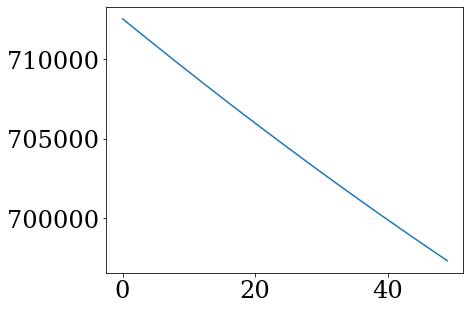

In [396]:
plt.plot(losses[-50:])

In [397]:
params.params

{'aberrations': {'na2a12jmq': Array([-26.90272   ,  12.631547  ,  -4.3491993 ,  -4.9081197 ,
          16.128248  ,  -7.8743744 ,  -0.5505699 ,  -6.5591893 ,
           0.7056569 , -10.372707  ,  -0.8096081 ,   1.456299  ,
           1.6618625 ,  -7.571117  ,   1.0561419 ,  -8.32137   ,
           2.5380647 ,  -0.46435708,  22.033976  ,   0.6104218 ,
          -3.2860138 ,   4.6440406 ,   2.1096485 ,   0.40467408,
           2.1529558 ,   7.7008924 ], dtype=float32),
  'na2a12jnq': Array([-23.254894 ,  12.167337 ,  -3.3931456,  -4.628588 ,  14.804314 ,
          -8.888217 ,  -2.3731737,  -4.5136185,   5.0069857, -12.814305 ,
          -1.0206971,   2.5758364,  -6.671053 ,  -5.467813 ,  -2.093703 ,
          -7.915797 ,   2.7535243,  -0.53319  ,  23.452908 ,   1.7252866,
          -3.7037954,   4.4937515,   4.8619905,   3.533908 ,   1.817708 ,
           7.47089  ], dtype=float32),
  'na2a12joq': Array([-20.011757  ,  16.733007  ,  -5.4961095 ,  -4.866834  ,
          14.925985  , -10.8

8


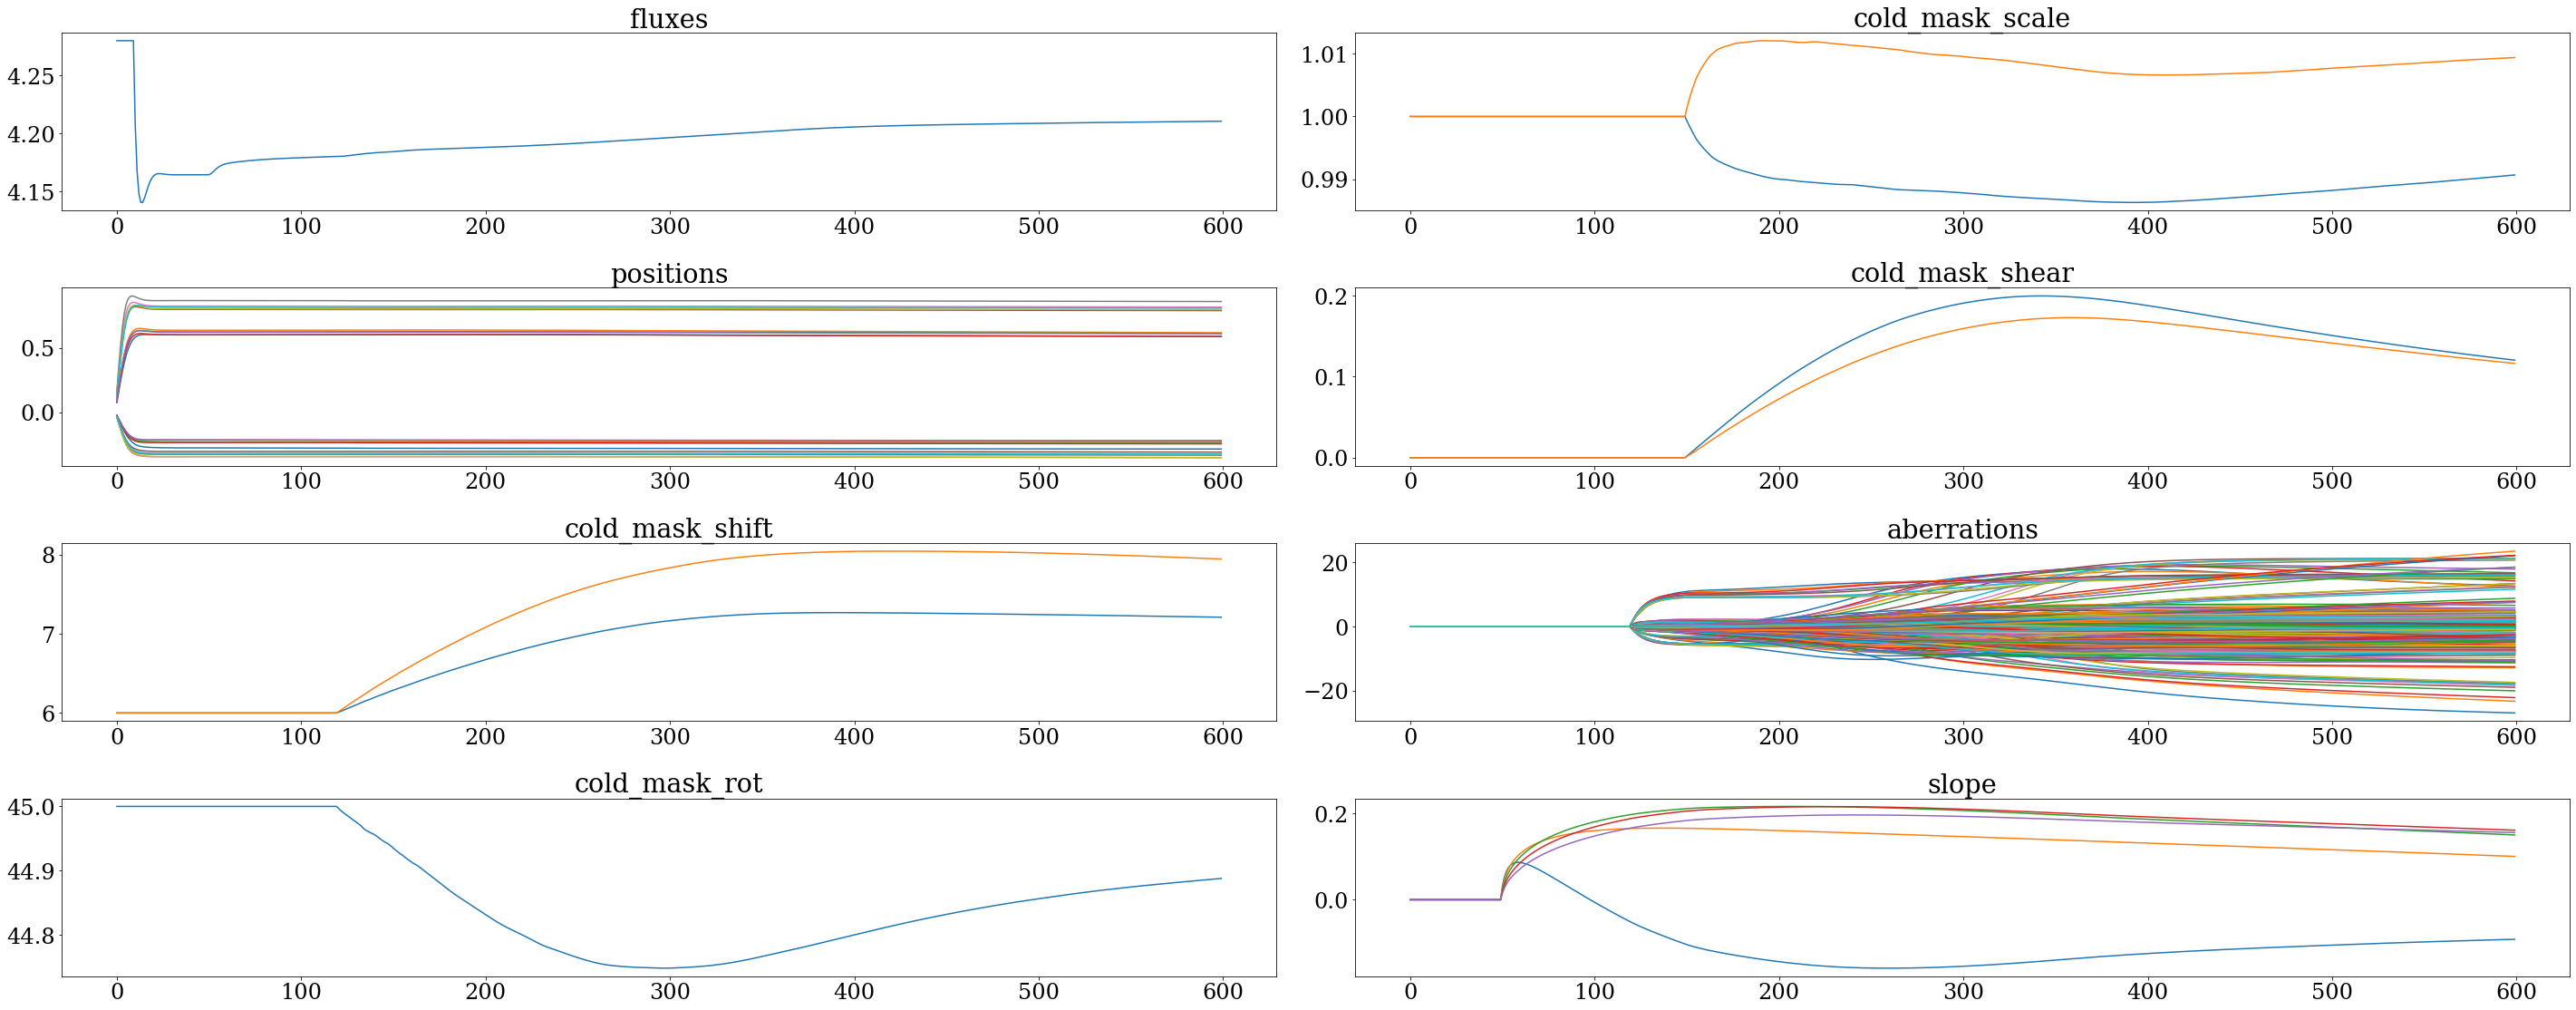

In [398]:
xw = 4
yw = int(np.ceil(len(groups)/xw))

print(len(groups))


fig, axs = plt.subplots(xw,yw,figsize=(xw*10,yw*8))
for i, param in enumerate(groups):
    #print(param)
    sp = axs[i%xw, i//xw]
    if param in ["fluxes", "contrast", "positions", "aberrations", 
                 "cold_mask_shift", "cold_mask_rot", "cold_mask_scale", "cold_mask_shear",
                 "primary_rot","primary_scale", "primary_shear", "slope"]:
        #print(np.asarray(list(models_s[0].get(param).values())))
        #print(injected_params[param])
        """for j in injected_params[param].values():
            print(j)
            print(len(j.shape))
            if len(j.shape)>0:
                for k in j:
                    sp.axhline(k, color='k', linestyle='--')
            else:
                sp.axhline(j, color='k', linestyle='--')"""
        for p in np.asarray([np.asarray(list(x.get(param).values())) for x in models]).T:
            if len(p.shape)>1:
                for i in range(p.shape[0]):
                    sp.plot(p[i,:])
            else:
                sp.plot(p)
            sp.set_title(param)
    else:
        sp.set_title(param)
        sp.plot([x.get(param) for x in models])
        #sp.axhline(injected_params[param], color='k', linestyle='--')

    
fig.tight_layout()

3.645253e+08, 6.973186e+05


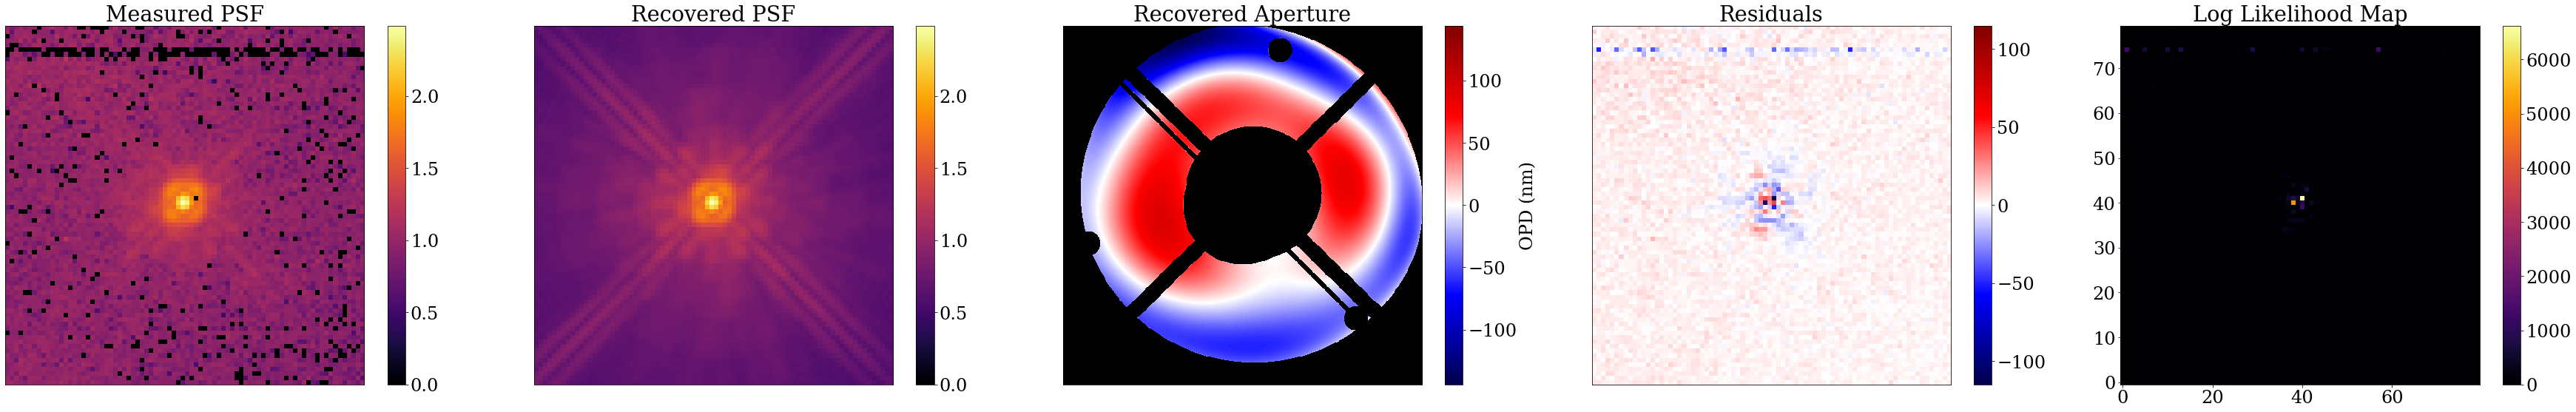

In [399]:
print(f"{float(losses[0]):e}, {float(losses[-1]):e}")

fig, axs = plt.subplots(1,5, figsize=(50,8))

fig.tight_layout()

cmap = matplotlib.colormaps['inferno']
cmap.set_bad('k',1)

#vm = max(np.max(cropped_data),np.max(telescope.model()))

exp = exposures[0]

model = params.inject(model)

coords = dlu.pixel_coords(512, 2.4)
cropped_frame = exp.data**0.125
telescope_frame = exp.fit(model,exp)**0.125

vm = max(np.nanmax(cropped_frame),np.nanmax(telescope_frame))
cd=axs[0].imshow(cropped_frame, vmin=0,vmax=vm,cmap=cmap)
plt.colorbar(cd,ax=axs[0])
tl=axs[1].imshow(telescope_frame, vmin=0, vmax=vm,cmap=cmap)
plt.colorbar(tl,ax=axs[1])
#axs[2].imshow(cropped_err)
cmap = matplotlib.colormaps['seismic']
cmap.set_bad('k',1)

optics = exp.fit.update_optics(model, exp)

support = optics.transmission(coords,2.4/512)
support_mask = support.at[support < .5].set(np.nan)

opd = optics.AberratedAperture.eval_basis(coords)*1e9
olim = np.max(np.abs(opd))
apt =axs[2].imshow(support_mask*opd,cmap=cmap,vmin=-olim, vmax=olim)
plt.colorbar(apt, ax=axs[2]).set_label("OPD (nm)")
#axs[4].imshow(telescope.detector.pixel_response.pixel_response)
resid = (exp.data - exp.fit(model,exp))/exp.err
rlim = np.nanmax(np.abs(resid))
resid=axs[3].imshow(resid, cmap='seismic',vmin=-rlim, vmax=rlim)
plt.colorbar(resid,ax=axs[3])

"""def pix2rad(x):
    return dlu.arcsec2rad(x*0.0432)

def rad2pix(x):
    return dlu.rad2arcsec(x)/0.0432

positions = dlu.positions_from_sep(
        pix2rad(model.get(exp.map_param("positions"))),
        pix2rad(model.params["separation"]),
        dlu.deg2rad(model.params["position_angle"])
    )

for i in range(2):
    x, y = rad2pix(positions[i]) + wid/2 - 0.5
    axs[3].axvline(x, color='gk'[i],linestyle='--')
    axs[3].axhline(y, color='gk'[i],linestyle='--')
"""

lpdf = posterior(model,exp,return_im=True)#*nanmap
lpd = axs[4].imshow(lpdf)
plt.colorbar(lpd, ax=axs[4])

axs[0].set_title("Measured PSF")
axs[1].set_title("Recovered PSF")
axs[2].set_title("Recovered Aperture")
axs[3].set_title("Residuals")
axs[4].set_title("Log Likelihood Map")


for i in range(4):
    axs[i].set_xticks([])
    axs[i].set_yticks([])

#axs[1].imshow(telescope.optics.aberrations.eval_basis(coords)*1e9)
plt.show()
#plt.imshow(np.abs(telescope.model()-cropped_data)**0.25)


In [400]:
#resid = (exp.data - exp.fit(model,exp))/exp.data
#print(np.nanmedian(np.abs(resid[50:-50,50:-50])))
#plt.imshow((np.abs(resid[50:-50,50:-50])))
#plt.colorbar()

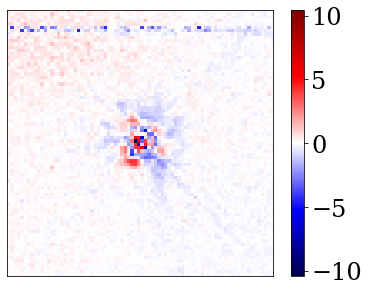

In [401]:
res = 0.0
for exp in exposures[:15]:#[:10]+exposures[11:]:
    res = res + np.nan_to_num(exp.data - exp.fit(model, exp), 0.0)/len(exposures)

#res = res.at[32:48,32:48].set(0.0)

res = res - np.mean(res)

#res = res.at[45:55,45:55].set(0.0)

#res = res.at[28:36,52:60].set(0.0)


m = np.max(np.abs(res))

plt.imshow((res), cmap='seismic', vmax=m, vmin=-m)
plt.xticks([])
plt.yticks([])
plt.colorbar()

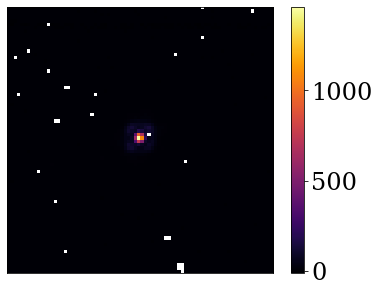

In [402]:
plt.imshow(exposures[0].data)
plt.xticks([])
plt.yticks([])
plt.colorbar()

In [403]:
fsh = calc_fishers(model, exposures, ["aberrations"], recalculate=True, save=False)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [404]:
uncs = []
for exp in fsh.keys():
    print(np.diag(np.linalg.inv(fsh[exp]["aberrations"]*80*80)))
    uncs.append(np.sqrt(abs(np.linalg.inv(fsh[exp]["aberrations"])[0,0])))
uncs = np.asarray(uncs)
uncs

[-5.20468457e-05 -1.89432740e-05  1.66587506e-06 -3.00428013e-07
 -2.14753641e-06 -1.30018589e-05 -1.26474421e-04 -7.24528072e-05
  5.18349566e-07 -4.92416038e-05 -2.27001525e-04 -2.86646373e-05
 -8.53883739e-06 -3.81951668e-06 -3.20536383e-05 -7.42638667e-06
 -7.83131327e-07 -7.92551930e-07 -4.66365309e-05 -2.46775307e-05
 -2.77461231e-06 -2.66167863e-05 -1.03761144e-04 -6.23192273e-06
 -6.94934579e-06 -1.31741845e-05]
[-4.23733800e-05 -8.58956446e-06 -1.31444585e-05 -4.54623978e-06
 -8.74428451e-07 -7.75164735e-05 -1.65858528e-05 -6.13923039e-05
 -4.52120003e-05 -1.02315062e-05 -3.72347095e-05 -1.13693764e-04
 -9.41595135e-06 -1.03528464e-05  1.72665136e-06 -2.36135220e-05
  5.25443329e-06 -6.07961101e-06 -5.49269353e-05 -2.29625985e-05
 -2.38859302e-05 -5.61451488e-05 -8.64755748e-06 -2.67774012e-05
 -5.84794179e-06 -6.40658909e-05]
[-5.5500270e-05 -9.3514418e-06 -1.0118817e-07 -1.6247978e-06
 -1.7947860e-06 -8.0930158e-06 -1.0086884e-05 -6.1225910e-05
 -9.8926548e-06 -6.0271382e-06

Array([0.5771569 , 0.5207614 , 0.59599566, 2.082858  , 0.71713597,
       2.0473816 , 0.42847452, 0.41282073, 0.45057678, 0.35778877],      dtype=float32)

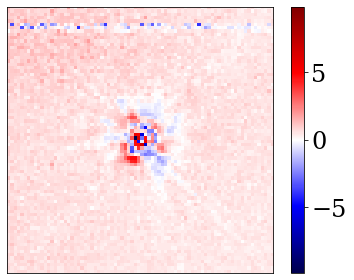

In [405]:
res = 0.0
for exp in exposures[:18]:#[:10]+exposures[11:]:
    res = res + np.nan_to_num(exp.data - exp.fit(model, exp), 0.0)/len(exposures)

#res = res.at[32:48,32:48].set(0.0)

#res = res.at[45:55,45:55].set(0.0)

#res = res.at[28:36,52:60].set(0.0)


m = np.max(np.abs(res))

plt.imshow((res), cmap='seismic', vmax=m, vmin=-m)
plt.xticks([])
plt.yticks([])
plt.colorbar()

0.06597222222222222


Text(0, 0.5, 'Defocus (nm)')

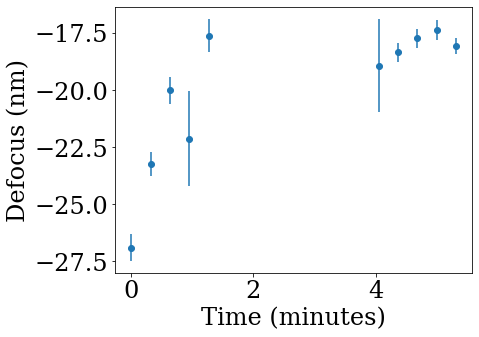

In [406]:
#orbit = 95/(24*60)

defocus = [x[0] for x in params.params["aberrations"].values()][:]
mjd = [exp.mjd for exp in exposures]#[:16]

mjd = [(x - mjd[0])*24*60 for x in mjd]

print(95/(24*60))

plt.errorbar(mjd, defocus, uncs, marker="o",linestyle='none')
#plt.scatter(mjd,defocus)
plt.xlabel("Time (minutes)")
plt.ylabel("Defocus (nm)")

In [407]:
from sklearn.decomposition import PCA

abb = np.asarray([x for x in params.params["aberrations"].values()])#.transpose()
print(abb.shape)

pca = PCA(n_components=5)
pca.fit(abb)
print(pca.singular_values_)
print(pca.components_)
print(pca.explained_variance_)
components = pca.components_

(10, 26)
[23.611458  14.901387   7.72394    6.605779   3.4821632]
[[-0.30259266 -0.45865247 -0.09740432  0.11027915 -0.03250067 -0.09681223
  -0.08942013 -0.03081054  0.16269183 -0.18427317  0.09150981 -0.07006329
  -0.23274474  0.12553322 -0.02523578 -0.06179319  0.10912943  0.00286103
   0.5872411   0.14171632 -0.16957986  0.20090829  0.0058455  -0.05152904
  -0.01151919  0.24528237]
 [ 0.40177074  0.17160316 -0.05262062  0.02384015 -0.06486212 -0.2144499
  -0.06425574  0.5109839   0.12246212 -0.04685943 -0.1429208  -0.03612464
  -0.48772675  0.3069695  -0.08455538 -0.17123596  0.057108   -0.02538958
  -0.07072812 -0.10554536 -0.06630506  0.11042191  0.16400151  0.11403568
  -0.02649506  0.07498421]
 [ 0.08282847  0.0075412   0.25000194 -0.11643311 -0.12470016 -0.03494763
  -0.10754786 -0.29185164  0.3757226  -0.00436594  0.12485583  0.2059889
  -0.30783314 -0.3261764  -0.27113503  0.01026992 -0.08550898  0.00492372
  -0.1002242   0.40244555 -0.027327   -0.00589527  0.17645253  0.306

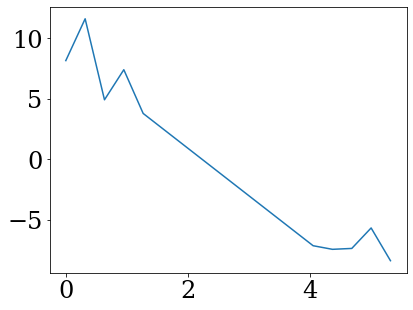

In [408]:
x = pca.transform(abb)
plt.plot(mjd, x[:,0])

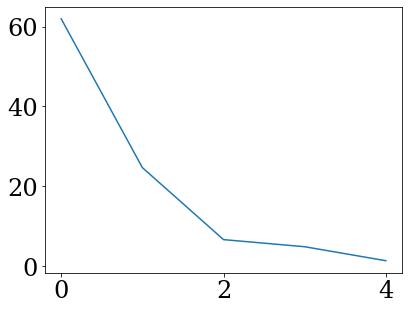

In [409]:
plt.plot(pca.explained_variance_)

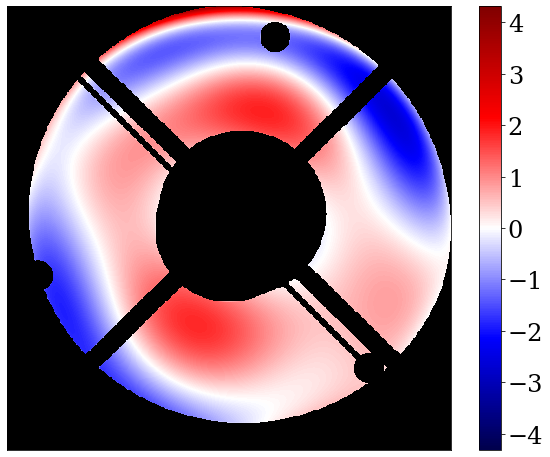

In [410]:
plt.figure(figsize=(10,8))
cmap = matplotlib.colormaps['seismic']
cmap.set_bad('k',1)

ap = dl.AberratedAperture(dl.CircularAperture(radius=1.2), noll_inds=np.arange(4,30), coefficients=components[0])

opd = ap.eval_basis(coords)#*1e9
m = np.max(np.abs(opd))
plt.imshow(opd*support_mask, cmap=cmap, vmin=-m, vmax=m)
plt.xticks([])
plt.yticks([])
plt.colorbar()
